# Data Sience Quick Setup

*When you need to do some Data Science very very quickly*

## Imports and styling

In [1]:
import os
import sys
import io
from pathlib import Path
import zipfile
import datetime
import itertools
import functools
from collections import defaultdict
import cloudpickle
import sqlite3
import numpy as np
import pandas as pd
import scipy
import json
from loguru import logger

from sklearn.base import BaseEstimator, RegressorMixin, ClassifierMixin, TransformerMixin, clone
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer, make_column_transformer, TransformedTargetRegressor
from sklearn.feature_selection import SelectKBest, RFE, f_regression, mutual_info_regression
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures, OrdinalEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, ElasticNet, LassoLarsCV, RidgeCV, LogisticRegression, LogisticRegression
from sklearn.naive_bayes import ComplementNB, BernoulliNB, MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier, RandomForestRegressor, RandomForestClassifier
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.model_selection import KFold, StratifiedKFold, TimeSeriesSplit, GridSearchCV, train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, confusion_matrix, balanced_accuracy_score, precision_recall_curve, f1_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.utils import resample, shuffle
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, SpectralClustering

import statsmodels.api as sm
from statsmodels.gam.api import GLMGam, BSplines
import lightgbm as lgb
import skopt
import shap

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import plotly.graph_objects as go

np.random.seed(42**3)

In [2]:
logger.remove()
logger.add(sys.stderr, format='{time} {level} {line}: {message}', level='DEBUG')

plt.style.use('seaborn')
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['figure.figsize'] = (5, 5)

np.set_printoptions(edgeitems=30, linewidth=10000)
pd.options.display.max_rows = 200
pd.options.display.max_columns = 80
pd.options.display.max_colwidth = 100

## Utility

In [3]:
def ht(df, n=2):
    display(pd.concat([df.head(n), df.tail(n)]))
    
def _get_value_range(x):
    vals = np.array(x.dropna().unique())
    if isinstance(vals, np.object) or isinstance(vals, np.int):
        if len(vals) < 10:
            return f'{vals} ({len(vals)})'
        else:
            return f'{vals.min()} - {vals.max()} ({len(vals)})'
    else:
        return f'{vals.min()} - {vals.max()}'

def describe_df(df):
    df_nan_rate = df.isnull().sum().rename('nans') / len(df)
    df_dtype = df.dtypes
    df_values = df.apply(_get_value_range, axis=0)

    df_desription = pd.DataFrame({
        'nan_rate': df_nan_rate,
        'dtype': df_dtype,
        'values': df_values,
    }).sort_values('nan_rate')
    display(df_desription)
    
def create_data(fname, foo, **foo_kwargs):
    fpath = Path(fname)
    data = foo(**foo_kwargs)
    cloudpickle.dump(data, open(fpath, 'wb'))
    logger.info(f'data is created and dumped to {fpath}')
    return data

def get_or_create_data(fname, foo, **foo_kwargs):
    fpath = Path(fname)
    if fpath.exists():
        data = cloudpickle.load(open(fpath, 'rb'))
        logger.info(f'data is loaded from {fpath}')
    else:
        data = foo(**foo_kwargs)
        cloudpickle.dump(data, open(fpath, 'wb'))
        logger.info(f'data is created and dumped to {fpath}')
    return data

## Custom models

In [4]:
class MinMaxClipper(TransformerMixin, BaseEstimator):
    def fit(self, X, y):
        self.x_min_ = np.min(X)
        self.x_max_ = np.max(X)
        return self
        
    def transform(self, X):
        return X.clip(self.x_min_, self.x_max_, axis=1)

class FixedGAM(RegressorMixin, BaseEstimator):
    def __init__(self, df=5, degree=3, alpha=0.1):
        self.df = df
        self.degree = degree
        self.alpha = alpha
    
    def fit(self, X, y):
        X = np.array(X)
        self.x_min_ = np.min(X, axis=0)
        self.x_max_ = np.max(X, axis=0)
        self.splines_ = BSplines(X, df=[self.df] * X.shape[1], degree=[self.degree] * X.shape[1]) 
        self.estimator_ = GLMGam(y, X, smoother=self.splines_, alpha=self.alpha)
        self.res_ = self.estimator_.fit()
        return self
    
    def predict(self, X):
        X = np.clip(X, self.x_min_, self.x_max_)
        return self.res_.predict(X, exog_smooth=X)

# EDA & Visualization Examples

In [5]:
df = pd.read_csv(
    os.path.join('data', 'dummy_loans.csv'), 
    parse_dates=['rep_loan_date', 'first_loan', 'first_overdue_date'],
)
ht(df)

,loanKey,rep_loan_date,first_loan,dpd_5_cnt,dpd_15_cnt,dpd_30_cnt,first_overdue_date,close_loans_cnt,federal_district_nm,TraderKey,payment_type_0,payment_type_1,payment_type_2,payment_type_3,payment_type_4,payment_type_5,past_billings_cnt,score_1,score_2,age,gender,bad_flag
0,708382,2016-10-06,2015-11-13,NaN,NaN,NaN,NaT,3.0,region_6,6,0,0,10,0,0,0,10.0,NaN,NaN,21.0,False,0
1,406305,2016-03-26,2015-09-28,1.0,0.0,0.0,2016-01-30,0.0,region_6,6,0,0,6,0,0,0,5.0,NaN,NaN,20.0,False,0
4155,730681,2016-10-14,2016-05-20,NaN,NaN,NaN,NaT,0.0,region_6,7,0,0,4,0,0,0,4.0,NaN,563.08978,35.0,False,0
4156,521420,2016-06-02,2015-12-08,2.0,2.0,0.0,2016-02-13,0.0,region_4,12,0,0,6,0,0,0,5.0,NaN,NaN,25.0,False,1


In [6]:
describe_df(df)

,nan_rate,dtype,values
loanKey,0.000000,int64,58567 - 884377
age,0.000000,float64,18.0 - 74.0
payment_type_5,0.000000,int64,[0]
payment_type_4,0.000000,int64,[0 1 3 5 7 2 4]
payment_type_3,0.000000,int64,0 - 35
payment_type_2,0.000000,int64,0 - 33
payment_type_1,0.000000,int64,0 - 81
gender,0.000000,bool,[False True]
TraderKey,0.000000,int64,1 - 80
payment_type_0,0.000000,int64,[0 2 3 1 4 15 5 6 8]


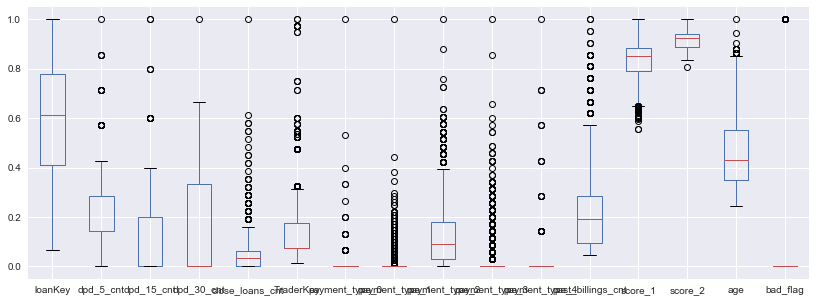

In [7]:
dft = df.select_dtypes(include=np.number).drop(columns='payment_type_5')
_ = (dft / dft.abs().max()).plot(kind='box', figsize=(14, 5))

skew 1.312
kurtosis 3.534


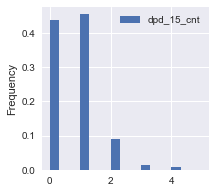

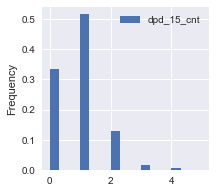

In [13]:
_ = (df.groupby('bad_flag')[['dpd_15_cnt']]
     .plot(kind='hist', bins=df['dpd_15_cnt'].dropna().unique(), density=1, width=0.3, figsize=(3, 3)))
print('skew', df['dpd_15_cnt'].skew().round(3))
print('kurtosis', df['dpd_15_cnt'].kurtosis().round(3))

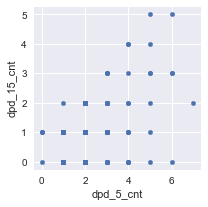

In [14]:
_ = df.plot(kind='scatter', x='dpd_5_cnt', y='dpd_15_cnt', figsize=(3, 3))

In [15]:
dft = df.select_dtypes(include=np.number).drop(columns='payment_type_5').corr()
np.fill_diagonal(dft.values, 0)
dft.abs().round(2).style.background_gradient(cmap='Blues')

,loanKey,dpd_5_cnt,dpd_15_cnt,dpd_30_cnt,close_loans_cnt,TraderKey,payment_type_0,payment_type_1,payment_type_2,payment_type_3,payment_type_4,past_billings_cnt,score_1,score_2,age,bad_flag
loanKey,0,0.01,0.11,0.04,0.23,0.02,0.01,0.02,0.22,0.13,0.02,0.32,0.02,0.12,0.04,0.11
dpd_5_cnt,0.01,0,0.47,0.17,0.15,0.04,0,0.02,0.16,0.03,0.01,0.22,0.05,0.07,0.12,0.07
dpd_15_cnt,0.11,0.47,0,0.51,0.15,0.01,0.01,0.02,0.1,0.08,0.02,0.15,0.03,0.14,0.01,0.07
dpd_30_cnt,0.04,0.17,0.51,0,0.07,0,0.03,0.03,0.04,0.05,0.04,0.12,0.16,0.02,0.07,0.06
close_loans_cnt,0.23,0.15,0.15,0.07,0,0.02,0.07,0.22,0.54,0.27,0.05,0.73,0.02,0.15,0.03,0.07
TraderKey,0.02,0.04,0.01,0,0.02,0,0.01,0.06,0.09,0.08,0.02,0.04,0,0.05,0.03,0.01
payment_type_0,0.01,0,0.01,0.03,0.07,0.01,0,0.02,0.02,0.03,0,0.04,0.01,0.08,0.01,0.02
payment_type_1,0.02,0.02,0.02,0.03,0.22,0.06,0.02,0,0.14,0.02,0.12,0.24,0.02,0.05,0.05,0.01
payment_type_2,0.22,0.16,0.1,0.04,0.54,0.09,0.02,0.14,0,0.24,0.04,0.71,0.04,0.02,0.08,0.06
payment_type_3,0.13,0.03,0.08,0.05,0.27,0.08,0.03,0.02,0.24,0,0,0.23,0.01,0.02,0.11,0.07


# Modelling Examples

In [16]:
# --- Objective functions ---

# --- Sklearn
# Reg: explained_variance, r2, neg_mean_absolute_error, neg_mean_squared_error, neg_root_mean_squared_error, neg_mean_squared_log_error
# Class: accuracy, balanced_accuracy, average_precision, f1, f1_weighted, neg_log_loss, precision, recall, roc_auc
# Clust: mutual_info_score

# --- LightGBM
# Reg: regression, regression_l1, huber, fair, poisson, quantile, mape
# Class: binary, multiclass, multiclassova, cross_entropy
# Rank: lambdarank, rank_xendcg

## Classification

In [17]:
df = pd.read_csv(
    os.path.join('data', 'dummy_loans.csv'), 
    parse_dates=['rep_loan_date', 'first_loan', 'first_overdue_date'],
)
df_train, df_test = train_test_split(df, test_size=0.3)
ht(df_train)

def create_features(df):
    df2 = {
        'dpd_5_cnt': df['dpd_5_cnt'],
        'dpd_15_cnt': df['dpd_15_cnt'],
        'payment_type_1': df['payment_type_1'],
        'payment_type_2': df['payment_type_2'],
        'age': df['age'],
        'gender': df['gender'].astype('int'),    
        'rep_loan_date_diff':(df['rep_loan_date']-df['first_loan']).dt.days,
        'first_overdue_date_diff':(df['first_overdue_date']-df['first_loan']).dt.days,
    }
    return pd.DataFrame(df2)
    
X_train = create_features(df_train)
X_test = create_features(df_test)
ht(X_train)
y_train = df_train['bad_flag']
y_test = df_test['bad_flag']

,loanKey,rep_loan_date,first_loan,dpd_5_cnt,dpd_15_cnt,dpd_30_cnt,first_overdue_date,close_loans_cnt,federal_district_nm,TraderKey,payment_type_0,payment_type_1,payment_type_2,payment_type_3,payment_type_4,payment_type_5,past_billings_cnt,score_1,score_2,age,gender,bad_flag
540,498468,2016-05-20,2015-10-19,NaN,NaN,NaN,NaT,2.0,region_4,6,0,0,2,4,0,0,6.0,NaN,NaN,19.0,False,0
3895,328499,2016-01-30,2015-02-28,NaN,NaN,NaN,NaT,2.0,region_2,12,0,6,0,0,1,0,11.0,611.116824,NaN,42.0,False,0
3088,847034,2016-12-07,2016-05-10,NaN,NaN,NaN,NaT,2.0,region_6,6,0,0,9,0,0,0,6.0,624.761014,NaN,52.0,False,0
1948,751012,2016-10-21,2016-08-05,NaN,NaN,NaN,NaT,0.0,region_1,12,0,0,1,1,0,0,2.0,627.054844,NaN,26.0,False,0


,dpd_5_cnt,dpd_15_cnt,payment_type_1,payment_type_2,age,gender,rep_loan_date_diff,first_overdue_date_diff
540,NaN,NaN,0,2,19.0,0,214,NaN
3895,NaN,NaN,6,0,42.0,0,336,NaN
3088,NaN,NaN,0,9,52.0,0,211,NaN
1948,NaN,NaN,0,1,26.0,0,77,NaN


### Logistic Regression

In [18]:
transformer1 = SimpleImputer(strategy='mean')
transformer2 = StandardScaler()

estimator = LogisticRegression(
    fit_intercept=True, 
    penalty='l2',
#     C=1.,
    class_weight=None,
    solver='liblinear',
    random_state=42
)

m = GridSearchCV(
    Pipeline((
        ('t1', transformer1),
        ('t2', transformer2),
        ('e', estimator),
    )),
    {
        'e__C': [0.1, 1., 10.],
    },
    scoring='neg_log_loss',
    cv=5,
    verbose=1,
)

_ = m.fit(X_train, y_train)

best = m.best_estimator_.steps[-1][-1]
print(best)
print(f'best cv score = {m.best_score_:.4f}')

y_train_hat = m.predict(X_train)
p_train_hat = m.predict_proba(X_train)
y_test_hat = m.predict(X_test)
                              
print(f'log loss (train) = {log_loss(y_train, p_train_hat[:, 0]):.4f}')
print(f'accuracy (train) = {accuracy_score(y_train, y_train_hat):.4f}')
print(f'b accuracy (train) = {balanced_accuracy_score(y_train, y_train_hat):.4f}')
print(f'b accuracy (test) = {balanced_accuracy_score(y_test, y_test_hat):.4f}')

display(pd.Series(np.concatenate([best.coef_[0], [best.intercept_[0]]]).round(2), 
                  index=np.concatenate([X_train.columns, ['intercept']])).to_frame().T)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.1s finished


LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=42, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)
best cv score = -0.3168
log loss (train) = 2.1547
accuracy (train) = 0.8976
b accuracy (train) = 0.5000
b accuracy (test) = 0.5000


,dpd_5_cnt,dpd_15_cnt,payment_type_1,payment_type_2,age,gender,rep_loan_date_diff,first_overdue_date_diff,intercept
0,0.07,0.06,0.08,0.15,-0.33,0.11,-0.57,-0.13,-2.23


### Sklearn GB Classifier

In [24]:
transformer1 = SimpleImputer(fill_value=-1)
transformer2 = OneHotEncoder(handle_unknown='ignore')

estimator = GradientBoostingClassifier(
    n_estimators=100, 
    min_samples_leaf=10,
    loss='deviance',
    subsample=1,
    random_state=42,
)

m = GridSearchCV(
    Pipeline((
        ('t1', transformer1),
        ('t2', transformer2),
        ('e', estimator),
    )),
    {
        'e__max_leaf_nodes': [15, 7, 3],
        'e__learning_rate': [0.001, 0.01, 0.1],
#         'subsample': [1., 0.7],
    },
    scoring='neg_log_loss',
    cv=5,
    verbose=1,
)

_ = m.fit(X_train, y_train, e__sample_weight=None)

best = m.best_estimator_.steps[-1][-1]
print(best)
print(f'best cv score = {m.best_score_:.4f}')

y_train_hat = m.predict(X_train)
p_train_hat = m.predict_proba(X_train)
y_test_hat = m.predict(X_test)
                              
print(f'log loss (train) = {log_loss(y_train, p_train_hat[:, 0]):.4f}')
print(f'accuracy (train) = {accuracy_score(y_train, y_train_hat):.4f}')
print(f'b accuracy (train) = {balanced_accuracy_score(y_train, y_train_hat):.4f}')
print(f'b accuracy (test) = {balanced_accuracy_score(y_test, y_test_hat):.4f}')

# explainer = shap.TreeExplainer(m.best_estimator_, data=X_train_)
# shap_values = explainer.shap_values(X_test_)
# shap.summary_plot(shap_values, X_test_.sample(frac=.5))

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:    9.1s finished


GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=3,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=10, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=42, subsample=1, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)
best cv score = -0.3151
log loss (train) = 2.2025
accuracy (train) = 0.8979
b accuracy (train) = 0.5017
b accuracy (test) = 0.5000


### LightGBM Classifier

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:    7.6s finished


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', is_unbalance=False, lambda_l2=1.0,
               learning_rate=0.1, max_depth=-1, min_child_samples=20,
               min_child_weight=0.001, min_data_in_leaf=10, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=3,
               objective='cross_entropy', random_state=None, reg_alpha=0.0,
               reg_lambda=0.0, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)
best cv score = -0.3028
log loss (train) = 2.3678
accuracy (train) = 0.8976
b accuracy (train) = 0.5059
b accuracy (test) = 0.5062


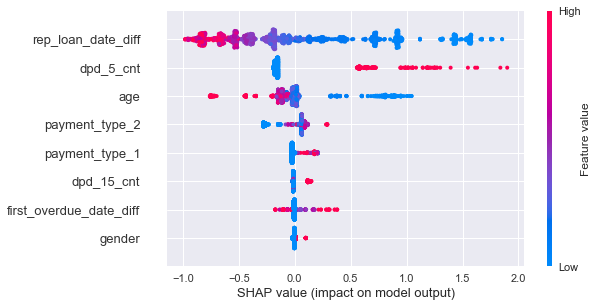

In [23]:
X_train_ = X_train.fillna(-1)
X_train_['gender'] = X_train_['gender'].astype('category')
X_test_ = X_test.fillna(-1)
X_test_['gender'] = X_test_['gender'].astype('category')

estimator = lgb.LGBMClassifier(
    n_estimators=100, 
    min_data_in_leaf=10,
    objective='cross_entropy',
    is_unbalance=False,
#     bagging_freq=1,
#     bagging_fraction=0.5,
#     monotone_constraints=(1, 1, 1, 1, 1, 1, 1, 1, -1, 0),
)

m = GridSearchCV(
    estimator,
    {
#         'is_unbalance': [True, False],
        'num_leaves': [15, 7, 3],
        'learning_rate': [0.001, 0.01, 0.1],
        'lambda_l2': [0, 0.01, 0.1, 1.],
#         'bagging_freq': [0, 1],
#         'bagging_fraction': [0.3],
    },
    scoring='neg_log_loss',
    cv=5,
    verbose=1,
)

_ = m.fit(X_train_, y_train)

best = m.best_estimator_
print(best)
print(f'best cv score = {m.best_score_:.4f}')

y_train_hat = m.predict(X_train_)
p_train_hat = m.predict_proba(X_train_)
y_test_hat = m.predict(X_test_)
                              
print(f'log loss (train) = {log_loss(y_train, p_train_hat[:, 0]):.4f}')
print(f'accuracy (train) = {accuracy_score(y_train, y_train_hat):.4f}')
print(f'b accuracy (train) = {balanced_accuracy_score(y_train, y_train_hat):.4f}')
print(f'b accuracy (test) = {balanced_accuracy_score(y_test, y_test_hat):.4f}')

explainer = shap.TreeExplainer(best, X_train.sample(frac=0.3))
shap_values = explainer.shap_values(X_test_, y_test)
shap.summary_plot(shap_values, X_test_)

## Regression

In [28]:
df = pd.read_csv(
    os.path.join('data', 'dummy_loans.csv'), 
    parse_dates=['rep_loan_date', 'first_loan', 'first_overdue_date'],
)
df_train, df_test = train_test_split(df, test_size=0.3)
ht(df_train)

def create_features(df):
    df2 = {
        'dpd_5_cnt': df['dpd_5_cnt'],
        'dpd_15_cnt': df['dpd_15_cnt'],
        'payment_type_1': df['payment_type_1'],
        'payment_type_2': df['payment_type_2'],
        'age': df['age'],
        'gender': df['gender'].astype('int'),    
        'rep_loan_date_diff':(df['rep_loan_date']-df['first_loan']).dt.days,
        'first_overdue_date_diff':(df['first_overdue_date']-df['first_loan']).dt.days,
    }
    return pd.DataFrame(df2)
    
X_train = create_features(df_train)
X_test = create_features(df_test)
ht(X_train)
y_train = df_train['bad_flag']
y_test = df_test['bad_flag']

,loanKey,rep_loan_date,first_loan,dpd_5_cnt,dpd_15_cnt,dpd_30_cnt,first_overdue_date,close_loans_cnt,federal_district_nm,TraderKey,payment_type_0,payment_type_1,payment_type_2,payment_type_3,payment_type_4,payment_type_5,past_billings_cnt,score_1,score_2,age,gender,bad_flag
291,303476,2015-12-29,2015-03-14,NaN,NaN,NaN,NaT,1.0,region_3,6,0,0,4,0,0,0,4.0,572.391571,NaN,25.0,True,1
4005,329784,2016-01-31,2015-10-08,NaN,NaN,NaN,NaT,1.0,region_6,22,0,0,3,0,0,0,3.0,609.989195,NaN,50.0,False,0
562,436378,2016-04-12,2015-04-15,NaN,NaN,NaN,NaT,2.0,region_3,38,0,3,9,0,0,0,11.0,572.696647,NaN,43.0,False,0
2241,670723,2016-09-19,2016-05-14,NaN,NaN,NaN,NaT,0.0,region_6,12,0,3,0,1,0,0,4.0,566.382907,NaN,23.0,True,1


,dpd_5_cnt,dpd_15_cnt,payment_type_1,payment_type_2,age,gender,rep_loan_date_diff,first_overdue_date_diff
291,NaN,NaN,0,4,25.0,1,290,NaN
4005,NaN,NaN,0,3,50.0,0,115,NaN
562,NaN,NaN,3,9,43.0,0,363,NaN
2241,NaN,NaN,3,0,23.0,1,128,NaN


### LinearRegression (ElasticNet)

In [30]:
transformer1 = SimpleImputer(strategy='mean')
transformer2 = StandardScaler()

estimator = ElasticNet(
    fit_intercept=True, 
    l1_ratio=.5,
#     alpha=1.,
    random_state=42
)

m = GridSearchCV(
    Pipeline((
        ('t1', transformer1),
        ('t2', transformer2),
        ('e', estimator),
    )),
    {
        'e__alpha': [0.1, 1., 10.],
    },
    scoring='neg_mean_squared_error',
    cv=5,
    verbose=1,
)

_ = m.fit(X_train, y_train)

best = m.best_estimator_.steps[-1][-1]
print(best)
print(f'best cv score = {m.best_score_:.4f}')

y_train_hat = m.predict(X_train)
y_test_hat = m.predict(X_test)
                              
print(f'MSE (train) = {mean_squared_error(y_train, y_train_hat):.4f}')
print(f'MAE (train) = {mean_absolute_error(y_train, y_train_hat):.4f}')
print(f'r2 (train) = {r2_score(y_train, y_train_hat):.4f}')
print(f'r2 (test) = {r2_score(y_test, y_test_hat):.4f}')

display(pd.Series(np.concatenate([best.coef_, [best.intercept_]]).round(3), 
                  index=np.concatenate([X_train.columns, ['intercept']])).to_frame().T)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.0s finished


ElasticNet(alpha=0.1, copy_X=True, fit_intercept=True, l1_ratio=0.5,
           max_iter=1000, normalize=False, positive=False, precompute=False,
           random_state=42, selection='cyclic', tol=0.0001, warm_start=False)
best cv score = -0.0920
MSE (train) = 0.0919
MAE (train) = 0.1839
r2 (train) = 0.0000
r2 (test) = -0.0006


,dpd_5_cnt,dpd_15_cnt,payment_type_1,payment_type_2,age,gender,rep_loan_date_diff,first_overdue_date_diff,intercept
0,0.0,0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.102


### GAM

In [31]:
transformer1 = SimpleImputer(strategy='mean')
transformer2 = StandardScaler()

estimator = FixedGAM(
    df=5,
    degree=3, 
#     alpha=0.1,
)

m = GridSearchCV(
    Pipeline((
        ('t1', transformer1),
        ('t2', transformer2),
        ('e', estimator),
    )),
    {
        'e__alpha': [0.1, 1., 10.],
#         'e__df': [5, 10],
    },
    scoring='neg_mean_squared_error',
    cv=5,
    verbose=1,
)

_ = m.fit(X_train, y_train)

print(m.best_estimator_.steps[-1][-1])
print(f'best cv score = {m.best_score_:.4f}')

y_train_hat = m.predict(X_train)
y_test_hat = m.predict(X_test)
                              
print(f'MSE (train) = {mean_squared_error(y_train, y_train_hat):.4f}')
print(f'MAE (train) = {mean_absolute_error(y_train, y_train_hat):.4f}')
print(f'r2 (train) = {r2_score(y_train, y_train_hat):.4f}')
print(f'r2 (test) = {r2_score(y_test, y_test_hat):.4f}')

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    1.2s finished


FixedGAM(alpha=1.0, degree=3, df=5)
best cv score = -0.0857
MSE (train) = 0.0829
MAE (train) = 0.1697
r2 (train) = 0.0980
r2 (test) = 0.0552


### LightGBM

In [32]:
estimator = lgb.LGBMRegressor(
    n_estimators=100, 
    min_data_in_leaf=10,
    objective='huber',
#     bagging_freq=1,
#     bagging_fraction=0.5,
)

m = GridSearchCV(
    estimator,
    {
        'num_leaves': [15, 7, 3],
        'learning_rate': [0.0001, 0.001, 0.01, 0.1],
        'lambda_l2': [0, 0.01, 0.1, 1.],
#         'bagging_freq': [0, 1],
#         'bagging_fraction': [0.3],
    },
    scoring='neg_mean_squared_error',
    cv=5,
    verbose=1,
)

_ = m.fit(X_train, y_train)

print(m.best_estimator_)
print(f'best cv score = {m.best_score_:.4f}')

y_train_hat = m.predict(X_train)
y_test_hat = m.predict(X_test)
                              
print(f'MSE (train) = {mean_squared_error(y_train, y_train_hat):.4f}')
print(f'MAE (train) = {mean_absolute_error(y_train, y_train_hat):.4f}')
print(f'r2 (train) = {r2_score(y_train, y_train_hat):.4f}')
print(f'r2 (test) = {r2_score(y_test, y_test_hat):.4f}')

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed:    8.0s finished


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', lambda_l2=0, learning_rate=0.1,
              max_depth=-1, min_child_samples=20, min_child_weight=0.001,
              min_data_in_leaf=10, min_split_gain=0.0, n_estimators=100,
              n_jobs=-1, num_leaves=3, objective='huber', random_state=None,
              reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0)
best cv score = -0.0842
MSE (train) = 0.0781
MAE (train) = 0.1603
r2 (train) = 0.1511
r2 (test) = 0.0426


# SQL Examples

In [33]:
evil_records = pd.read_csv(os.path.join('data', 'evil_data.csv'))
display(evil_records)

db_path = os.path.join('db', 'main.db')

with sqlite3.connect(db_path) as conn:
    c = conn.cursor()
    try:
        c.execute("""DROP TABLE EVIL_INVADERS""")
    except:
        print('Warning: The table does not exist')
    
with sqlite3.connect(db_path) as conn:
    c = conn.cursor()

    c.execute("""\
        CREATE TABLE EVIL_INVADERS (
           ID TEXT PRIMARY KEY,
           AGE INTEGER,
           POWER_LVL FLOAT
        )
        """
    )
    
with sqlite3.connect(db_path) as conn:
    try:
        c = conn.cursor()
        c.executemany(
            """INSERT INTO EVIL_INVADERS VALUES (?,?,?)""",
            evil_records.values.tolist()
        )
    except:
        conn.rollback()
        raise
    else:
        conn.commit()

with sqlite3.connect(db_path) as conn:
    c = conn.cursor()
    evil_records_db = c.execute(
        """SELECT * FROM EVIL_INVADERS WHERE POWER_LVL > ?""",
        [0]
    ).fetchall()
    columns = c.execute("""PRAGMA table_info(EVIL_INVADERS)""").fetchall()
    evil_records_db = pd.DataFrame(evil_records_db, columns = [x[1] for x in columns])
display(evil_records_db)

,id,age,power_lvl
0,Shrimp,45,1.20
1,Alaska Doom,17,1.04
2,Minni Manny,23,16.50


,ID,AGE,POWER_LVL
0,Shrimp,45,1.20
1,Alaska Doom,17,1.04
2,Minni Manny,23,16.50


# Statistics Examples

## Basic statistics

In [61]:
a = np.random.normal(0, 1, size=50)
b = a + np.random.normal(0, 1.5, size=50)

print(f'a mean = {np.sum(a) / len(a):.2f} | {np.mean(a):.2f}')
print(f'a var = {np.sum((a - np.mean(a)) ** 2) / (len(a)-1):.2f} | {np.var(a, ddof=1):.2f} | {scipy.var(a, ddof=1):.2f}')
print(f'a skew = {np.mean((a - np.mean(a)) ** 3) / np.std(a) ** 3:.2f} | {scipy.stats.skew(a):.2f}')
print(f'a b covar = {np.cov(a, b, ddof=1)[0, 1]:.2f}')
print(f'a b corr = {np.corrcoef(a, b)[0, 1]:.2f}')
print(f'a b corr = {np.corrcoef(a, b)[0, 1]:.2f}')
print(f'a b kendall = {scipy.stats.kendalltau(a, b)[0]:.2f}')
print(f'a b spearman = {scipy.stats.spearmanr(a, b)[0]:.2f}')

a mean = -0.07 | -0.07
a var = 1.14 | 1.14 | 1.14
a skew = 0.02 | 0.02
a b covar = 1.32
a b corr = 0.62
a b corr = 0.62
a b kendall = 0.40
a b spearman = 0.52


## Sample descriptive statistics

In [62]:
df = pd.DataFrame({
    'a': np.arange(20),
    'b': np.arange(20),
    'c': np.linspace(0, 1, 20) ** 2,
})
df['d'] = df['a'] + df['b'] + df['c'] * 5 + np.random.normal(0, 1., size=20)

# - aggregate stats
ht(df)
display(df.agg(['mean', 'median', 'var', 'std'], axis=0))

# - correlation and collinearity
corr_mtx = df[['a', 'b', 'c']].corr()
display(corr_mtx.round(2))
for i in range(0, corr_mtx.shape[0]):
    for j in range(i+1, corr_mtx.shape[0]):
        if corr_mtx.iloc[i, j] > 0.99:
            print('collinear columns:', df.columns[i], df.columns[j], corr_mtx.iloc[i, j])
df = df.drop(columns='b')

# - outliers
ss = np.random.standard_t(2, size=100)
display(df.loc[np.abs(scipy.stats.zscore(df['a'])) > 2])

,a,b,c,d
0,0,0,0.000000,-1.742465
1,1,1,0.002770,2.168257
18,18,18,0.897507,40.968761
19,19,19,1.000000,41.022842


,a,b,c,d
mean,9.50000,9.50000,0.342105,20.421704
median,9.50000,9.50000,0.250693,19.137379
var,35.00000,35.00000,0.104043,176.903985
std,5.91608,5.91608,0.322557,13.300526


,a,b,c
a,1.00,1.00,0.97
b,1.00,1.00,0.97
c,0.97,0.97,1.00


collinear columns: a b 1.0


,a,c,d


## Scipy distributions

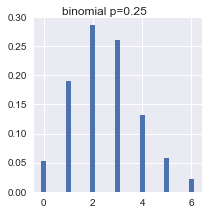

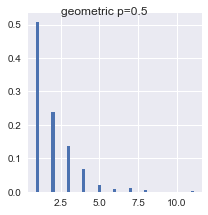

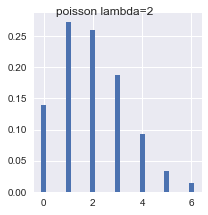

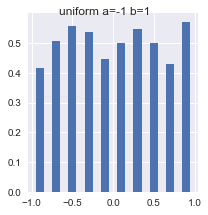

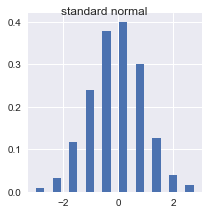

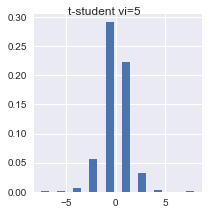

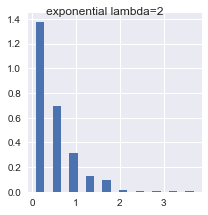

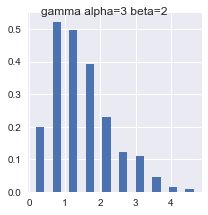

In [71]:
# binomial: E(X) = p*n, Var(X) = p*(1-p)*n
plt.figure(figsize=(3,3), tight_layout=True)
a = scipy.stats.binom(n=10, p=0.25).rvs(size=1000)
plt.hist(a, bins=np.unique(a), density=1, rwidth=0.2, align='left')
_ = plt.suptitle('binomial p=0.25')

# geometric: E(X) = 1/p, Var(X) = (1-p) / p^2
plt.figure(figsize=(3,3), tight_layout=True)
a = scipy.stats.geom(p=0.5).rvs(size=1000)
plt.hist(a, bins=np.unique(a), density=1, rwidth=0.2, align='left')
plt.suptitle('geometric p=0.5')

# poisson: E(X) = lambda, Var(X) = lambda
plt.figure(figsize=(3,3), tight_layout=True)
a = scipy.stats.poisson(mu=2).rvs(size=1000)
plt.hist(a, bins=np.unique(a), density=1, rwidth=0.2, align='left')
plt.suptitle('poisson lambda=2')

# -----

# uniform: E(X) = (a+b)/2, Var(X)=a*b/12
plt.figure(figsize=(3,3), tight_layout=True)
a = scipy.stats.uniform(loc=-1, scale=2).rvs(size=1000)
# print(a.sta)
plt.hist(a, density=1, rwidth=0.5, align='mid')
plt.suptitle('uniform a=-1 b=1')

# normal: E(X) = mu, Var(X) = sigma^2
plt.figure(figsize=(3,3), tight_layout=True)
a = scipy.stats.norm(loc=0, scale=1).rvs(size=1000)
plt.hist(a, density=1, rwidth=0.5, align='mid')
plt.suptitle('standard normal')

# t-student: E(X) = mu, Var(X) = vi/(vi-2) * sigma^2
plt.figure(figsize=(3,3), tight_layout=True)
a = scipy.stats.t(df=5, loc=0, scale=1).rvs(size=1000)
plt.hist(a, density=1, rwidth=0.5, align='mid')
plt.suptitle('t-student vi=5')

# exponential: E(X) = 1/lambda, Var(X) = 1/lambda^2
plt.figure(figsize=(3,3), tight_layout=True)
a = scipy.stats.expon(scale=1/2).rvs(size=1000)
plt.hist(a, bins=10, density=1, rwidth=0.5, align='mid')
plt.suptitle('exponential lambda=2')

# gamma: E(X) = alpha/beta, Var(X) = alpha/beta^2
# alpha = 1 -> exponential
plt.figure(figsize=(3,3), tight_layout=True)
a = scipy.stats.gamma(a=3, scale=1/2).rvs(size=1000)
plt.hist(a, bins=10, density=1, rwidth=0.5, align='mid')
_ = plt.suptitle('gamma alpha=3 beta=2')

## Confidence intervals

In [63]:
# - estimation of p for binomial distribution
n = 30
tails = 10
p = tails / n
sigma = np.sqrt(p * (1-p) / (n - 1))

# - approximate at normal (using CDF inverse)
print(f'conf interval = {scipy.stats.norm.ppf([0.025, 0.975], loc=p, scale=sigma)}')

# - approximate at normal (using CDF)
c1 = scipy.optimize.root_scalar(lambda x: scipy.stats.norm.cdf(x, loc=p, scale=sigma) - 0.025, x0=p, x1=p-0.01, method='secant')
c2 = scipy.optimize.root_scalar(lambda x: scipy.stats.norm.cdf(x, loc=p, scale=sigma) - 0.975, x0=p, x1=p+0.01, method='secant')
print(f'conf interval = {[c1.root, c2.root]}')

# - using MC simulations
N = 1000000
# arr = np.random.binomial(p=p, n=n, size=N)
p_samples = scipy.stats.binom.rvs(p=p, n=n, size=N) / n
p_samples = np.sort(p_samples)
c1 = p_samples[int(N*0.025)]
c2 = p_samples[int(N*0.975)]
print(f'conf interval = {[c1, c2]}')

conf interval = [0.16176275 0.50490392]
conf interval = [0.16176274710435318, 0.5049039195623135]
conf interval = [0.16666666666666666, 0.5]


## Equal sample mean test

t-test pval for equal means = 0.919
MC simulation proba for mean diff less than 0.1 = 0.832


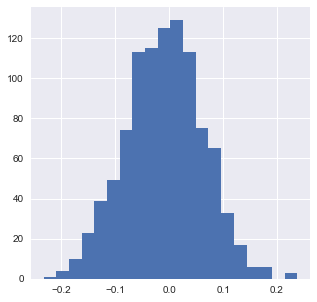

In [75]:
a = np.random.normal(0, 1, size=1000)
b = np.random.normal(0, 2, size=1000)

tstat, tpval = scipy.stats.ttest_ind(a, b, equal_var=False)
print(f't-test pval for equal means = {tpval:.3f}')

n = 1000
a_b_mean_diff = []
for i in range(n):
    a_mean = np.mean(np.random.choice(a, size=len(a), replace=True))
    b_mean = np.mean(np.random.choice(b, size=len(b), replace=True))
    a_b_mean_diff.append(a_mean-b_mean)
a_b_mean_diff = np.array(sorted(a_b_mean_diff))
_ = plt.hist(a_b_mean_diff, bins=20)
ci = 0.1
print(f'MC simulation proba for mean diff less than {ci} = {np.mean(np.abs(a_b_mean_diff) < ci)}')

## MLE vs. Method of Moments

- estimate lambda fitting both loc and scale
loc = 0.00
lambda = 1.98

- estimate lambda via MLE
lambda = 1.98

- estimate lambda via method of moments
lambda = 1.98


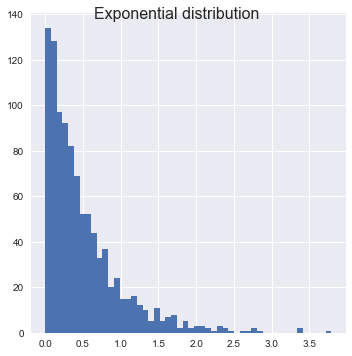

In [78]:
# - estimate 
a = scipy.stats.expon.rvs(scale=1/2, size=1000)
_ = plt.hist(a, bins=50)
plt.suptitle('Exponential distribution', fontsize=16)
plt.tight_layout()

loc_scale_fit = scipy.stats.expon.fit(a)
print('- estimate lambda fitting both loc and scale')
print(f'loc = {loc_scale_fit[0]:.2f}')
print(f'lambda = {1. / loc_scale_fit[1]:.2f}')

lambda_fit = scipy.optimize.minimize(lambda x: -np.mean(scipy.stats.expon.logpdf(a, scale=1./x)), x0=1., bounds=[(0, None)])
print()
print('- estimate lambda via MLE')
print(f'lambda = {lambda_fit.x[0]:.2f}')

print()
print('- estimate lambda via method of moments')
print(f'lambda = {1. / np.mean(a):.2f}')

## Linear Regression Estimator

In [81]:
class CustomLR(RegressorMixin, BaseEstimator):
    def __init__(self):
        pass
    
    def fit(self, X, y):
        # y = X*b + e
        # (y - X*b) ^ 2 -> min  =>  -2*X_T * (y - X*b) = 0  =>  X_T*y = X_T*X*b  =>  b = (X_T*X)^(-1) * X_T * y
        X = np.array(X)
        y = np.array(y)
        assert len(X.shape) == 2
        assert len(y.shape) == 1
        self.coef_ = scipy.linalg.solve(np.dot(X.T, X), np.dot(X.T, y))
#         self.coef_ = scipy.linalg.lstsq(X, y)[0]
        return self
        
    def predict(self, X):
        X = np.array(X)
        assert len(X.shape) == 2
        return np.dot(X, self.coef_)
    
    
X = np.random.normal(size=(100, 3))
y = X[:, 0] + 2*X[:, 1] - 2*X[:, 2] + np.random.normal(scale=0.1, size=100)

m = CustomLR()
m.fit(X, y)
y_hat = m.predict(X)
print(m.coef_.round(3))
print(mean_squared_error(y, y_hat).round(4))

[ 1.005  2.014 -1.997]
0.0095


## Linear Regression Statistics

In [97]:
# --- all statistics via statsmodels OLS
df = pd.DataFrame({
    'x1': np.arange(20),
    'x2': np.linspace(0, 1, 20) ** 2,
})
df['y'] = df['x1'] * 2 + df['x2'] * 5 + np.random.normal(0, 1., size=20)

X = df.drop(columns='y')
y = df['y']
mres = sm.OLS(y, exog=X).fit()
# print(mres.params)
display(mres.summary())

# --- all statistics manually
m = LinearRegression(fit_intercept=False)
m.fit(X, y)
print()
display(pd.Series(m.coef_, index=X.columns).rename('coeffients').to_frame().T.round(3))

# - R2
print(f'r2 = {1 - np.var(y_-y_hat)/np.var(y_):.3f}')

# - noise variance estimate
y_hat = m.predict(X)
y_ = np.array(y)
sigma2 = np.var(y_-y_hat, ddof=1+X.shape[1])
print(f'sigma2 estimate = {sigma2:.3f}')

# - T-scores & p-values
coef = m.coef_
coef_std = np.sqrt(sigma2 * np.diag(np.linalg.inv(np.dot(X.T, X))))
coef_tscore = coef / coef_std
print(f'T-scores = {coef_tscore.round(3)}')
coef_pval = 2 * scipy.stats.t(df=20-X.shape[1]-1).sf(coef_tscore)
print(f'P-values = {coef_pval.round(5)}')

# - confidence intervals
c1_01 = scipy.stats.t(df=20-X.shape[1]-1).ppf(0.025)
c2_01 = scipy.stats.t(df=20-X.shape[1]-1).ppf(0.975)
coef_c1 = coef + c1_01 * coef_std
coef_c2 = coef + c2_01 * coef_std
print(f'95% confidence intervals:')
print(np.vstack([coef_c1, coef_c2]).T.round(3))

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.999
Model:                            OLS   Adj. R-squared (uncentered):              0.998
Method:                 Least Squares   F-statistic:                              6384.
Date:                Mon, 16 Mar 2020   Prob (F-statistic):                    2.17e-26
Time:                        22:16:20   Log-Likelihood:                         -26.600
No. Observations:                  20   AIC:                                      57.20
Df Residuals:                      18   BIC:                                      59.19
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.9339      0.078     24.874      0.000       1.771       2.097
x2             6.3664      1.860      3.424      0.003       2.460      10.273
==============================================================================
Omnibus:                        6.068   Durbin-Watson:                   2.095
Prob(Omnibus):                  0.048   Jarque-Bera (JB):                3.889
Skew:                          -1.035   Prob(JB):                        0.143
Kurtosis:                       3.617   Cond. No.                         96.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

,x1,x2
coeffients,1.934,6.366


r2 = 0.994
sigma2 estimate = 0.979
T-scores = [24.246  3.337]
P-values = [0.     0.0039]
95% confidence intervals:
[[ 1.766  2.102]
 [ 2.341 10.391]]


## Logistic Regression Estimator

In [5]:
def deviance(b, X, y, c):
    p1 = 1 / (1+np.exp(-X @ b))
    loglik = y @ np.log(p1) + (1-y) @ np.log(1-p1)
    return -2*loglik + c * np.sum(np.abs(b))

class CustomLR(RegressorMixin, BaseEstimator):
    """
    log p_i/(1-p_i) = b*x_i <=> p_i = 1 / 1+exp(-b*x_i)
                                1-p_i = 1 / 1+exp(b*x_i)

    loglikelihood(b) = sum_i log(y_i*p_i + (1-y_i)*(1-p_i))
                     = sum_i log(y_i / 1+exp(-b*x_i) + (1-y_i) / 1+exp(b*x_i))
    """
    def __init__(self, c=0.1):
        self.c = c
    
    def fit(self, X, y):
        self.res_ = scipy.optimize.minimize(deviance, x0=np.zeros(X.shape[1]), args=(X, y, self.c))
        self.coef_ = self.res_.x
        return self
    
    def predict_proba(self, X):
        return 1 / (1+np.exp(-X @ self.coef_))
    
    def predict(self, X):
        return (self.predict_proba(X) > 0.5).astype(int)
    
    
X = np.random.normal(0, 1, size=(100, 2))
y = (np.sum(X, axis=1) + np.random.normal(0, 0.5, size=100) > 0).astype(int)

m = CustomLR()
m.fit(X, y)
y_hat = m.predict(X)
print(m.coef_)
print(accuracy_score(y, y_hat))

[3.17085943 2.61414412]
0.87


# Numerical Examples

## Integration

In [7]:
print(scipy.integrate.quad(lambda x: x**2, 0, 1)[0])
print(scipy.integrate.trapz([x**2 for x in np.linspace(0, 1, 50)], dx=1/50))

0.33333333333333337
0.326734693877551


## Find a minimum

In [106]:
# scipy.optimize.minimize(lambda x: x**2, x0=.5, method='BFGS', bounds=None)
scipy.optimize.minimize(lambda x: np.tan(x)**2, x0=.5, bounds=[(-1, 1)])

      fun: array([9.53735226e-16])
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-5.17652079e-08])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 12
      nit: 4
   status: 0
  success: True
        x: array([-3.08826039e-08])

## Find a root

In [107]:
scipy.optimize.root_scalar(lambda x: x**2 - 2, x0=1, x1=1.1, method='secant')

      converged: True
           flag: 'converged'
 function_calls: 7
     iterations: 6
           root: 1.4142135623730951

## Matrix inverse and decompositions

In [108]:
A = np.random.normal(size=(2, 2))
print(A)
print(scipy.linalg.inv(scipy.linalg.inv(A)))

Q, R = scipy.linalg.qr(np.random.normal(size=(2, 2)))
print()
print(Q)
print(R)

U, D, V = scipy.linalg.svd(np.random.normal(size=(2, 3)))
print()
print(U)
print(D)
print(V)

R = np.random.normal(size=(2, 2))
print()
print(R)

R_ = scipy.linalg.cholesky(np.matmul(R, R.T))
print(R_)

[[-0.4593584   0.70978354]
 [ 0.74950741 -1.0715049 ]]
[[-0.4593584   0.70978354]
 [ 0.74950741 -1.0715049 ]]

[[-0.49212179  0.87052636]
 [ 0.87052636  0.49212179]]
[[ 0.8153343   0.70298356]
 [ 0.         -0.24799942]]

[[-0.47845333  0.87811299]
 [ 0.87811299  0.47845333]]
[1.63749806 1.04668338]
[[-0.13477292 -0.97485074  0.17748887]
 [-0.92090349  0.18934731  0.34071154]
 [ 0.36574994  0.11753143  0.92326234]]

[[-0.96799588 -0.10462038]
 [-1.02339516  0.26239565]]
[[0.97363312 0.98927445]
 [0.         0.3708439 ]]


## Matrix equations

In [109]:
# A = B * x
B = np.random.normal(size=(3, 3))
x = np.random.normal(size=3)
print(x)
A = np.dot(B, x)
x_ = scipy.linalg.solve(B, A)
print(x_)
x_, rank, N, s = scipy.linalg.lstsq(B, A, cond=None)
print(x_)

[-0.63652328  1.30220976 -0.40526173]
[-0.63652328  1.30220976 -0.40526173]
[-0.63652328  1.30220976 -0.40526173]
